In [1]:
"""
Created on Thu Oct 12 11:29:03 2023

@author: yajiluck
"""


#This will run without a path variable as long as the Data Folder holding all the information
#For the assignment is located in the same directory as this script. Otherwise, PATH should be the path
#To the directory of the Data Folder.


PATH = ""



import numpy as np 
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt 
#Import for Part 1
import sklearn
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier





#Printing Imports and their versions used for this notebook

if hasattr(np, '__version__'):
    print(f"The version of {np.__name__} is {np.__version__}")

else:
    print(f"{np.__name__} does not have a version attribute.")


if hasattr(cv2, '__version__'):
    print(f"The version of {cv2.__name__} is {cv2.__version__}")

else:
    print(f"{cv2.__name__} does not have a version attribute.")


if hasattr(matplotlib, '__version__'):
    print(f"The version of {matplotlib.__name__} is {matplotlib.__version__}")

else:
    print(f"{matplotlib.__name__} does not have a version attribute.")


if hasattr(sklearn, '__version__'):
    print(f"The version of {sklearn.__name__} is {sklearn.__version__}")

else:
    print(f"{sklearn.__name__} does not have a version attribute.")

The version of numpy is 1.21.5
The version of cv2 is 4.5.1
The version of matplotlib is 3.5.1
The version of sklearn is 1.0.2


In [3]:

#Definition of my Image class to simplify image operations


class Image:
    def __init__(self, path, shape = (128,128)):
        # Reading the image using OpenCV
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            raise ValueError(f"Could not open or find the image at path: {path}")
            
        self.shape = shape     
            
        # Converting the image from BGR to RGB format
        self.img_rgb = np.array(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        
        #Gray Scale Image used for part2 
        self.img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        #Resize the image based on the shape argument of the object call    
        self.img_gray = cv2.resize(self.img_gray, (shape[0], shape[1]))
    
        # Extracting the image name from the path (without the extension of .png or .jpg)
        self.img_name = os.path.splitext(os.path.basename(path))[0]
        
        #Label defaulted to first substring of img_name before underscore
        self.label = self.img_name.split('_')[0]
        
                
    #Sets label of an image
    def set_label(self,label):
        self.label = label
        
    #get image from img_object
    def get_data(self):
        return self.img_rgb
    #Get name from img_object
    def get_name(self):
        return self.img_name
    #Display img_obj
    def display(self, title = None, image = None, gray = False):
        
        if title is None:
            title = self.img_name
            
        if image is None:
            image = self.img_rgb
            
        """Display the image using Matplotlib"""
        
        if gray:
            
            image = self.img_gray
            plt.imshow(image, cmap = 'gray')
        else:
            plt.imshow(image)
            
        plt.title(title)
        plt.axis('off')  # to hide axis
        plt.show()

In [4]:

#HoG Descriptor class. This class takes an image object and applies the operation of part
#1 of the assignmnet.



class HoGDescriptor:
    def __init__(self, image_obj : Image):
        
        self.image_obj = image_obj
        #Set image of HoG Descriptor to resized gray image
        self.image = image_obj.img_gray
        

        #Set up HoG descriptor of size (32 x 32 x 8) for a 128 x 128 image
        
        #This means we have 32 x 32 blocks each of size 4 x 4 
        #(They separate the 128 x 128 image into 32 x 32 blocks)
        #Block stride is equal to block size as to not have overlapping blocks
        #Cell size is equal to block size so no block-level concatenation
        
        self.n_bins = 8
        self.cell_size = (4,4)
        
        
        
        self.hog = cv2.HOGDescriptor(self.image_obj.shape,  # winSize
                                     (4, 4),    # blockSize
                                     (4, 4),    # blockStride
                                     self.cell_size,    # cellSize
                                     self.n_bins)           # nbins 
        
        self.features = None
        self.classifier = None

    #Function to compute HoG Features
    def compute_features(self):
        self.features = self.hog.compute(self.image)
        
    #Helper function to help vizualize hog features
    def visualize_hog(self):
        
        #Make sure features are computed before visualizing
        if self.features is None:
            print('Features not computed yet!')
            return
        
        """Visualize HOG features on an image."""
        hog_image = np.zeros_like(self.image, dtype=np.float32)
    
        # Total cells in x and y direction
        total_cells_x = self.image.shape[1] // self.cell_size[1]
        total_cells_y = self.image.shape[0] // self.cell_size[0]
    
        cell_dim = self.image.shape[0] // total_cells_y
    
        for y in range(total_cells_y):
            for x in range(total_cells_x):
                for bin in range(self.n_bins):  # Assuming 8 bins
                    angle = (bin * 45) * np.pi / 180.0
                    magnitude = self.features[((y * total_cells_x) + x) * 8 + bin]
                    cx, cy = (x + 0.5) * cell_dim, (y + 0.5) * cell_dim
                    dx = magnitude * np.cos(angle) * self.cell_size[0]
                    dy = magnitude * np.sin(angle) * self.cell_size[1]
                    cv2.line(hog_image, (int(cx - dx), int(cy - dy)), (int(cx + dx), int(cy + dy)), (255,255,255), 1)
    
        return hog_image
            
            
    #Function to display Hog Features
    def display(self):
       """Display the HOG features using matplotlib"""
       if self.features is not None:
           hog_image = self.visualize_hog()
      
           plt.figure(figsize=(10, 10))
           plt.imshow(hog_image, cmap='gray')
           plt.axis('off')
           plt.title(self.image_obj.img_name + ' Hog Descriptors')
           plt.show()
           
                      
       else:
           print("Features have not been computed yet!")
   

In [5]:
#K-Classifier Class that takes HogDescriptor Objects to train a classifier.
#This object takes a path to the training images. Assuming all images are png and are named as follows:
#Image_name = label_restofname

class KClassifier:
    def __init__(self, training_path, testing_path, n_neighbors=3):
        self.training_images = [] #Will hold all training image objects
        self.training_features = [] #Will hold all training image features
        self.training_labels = [] #Will hold all training image labels
        self.training_path = training_path
        self.testing_path = testing_path
        
        self.hog_descriptors_train = [] #Will hold all HoG Objects
        self.hog_descriptors_test = [] #Will hold all HoG Objects
        
        self.classifier = None
        self.n_neighbors = n_neighbors #n_neighbors from initialization      
        self.load_and_compute_features() #Creates classifier
    
    
    #Take training path to load images
    def load_and_compute_features(self):
        for filename in os.listdir(self.training_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other formats if needed
                #full path of image being iterated
                path = os.path.join(self.training_path, filename)
                
                # Create Image and HoGDescriptor objects for each image and compute features.
                #Resize images to 128 by 128
                image_obj = Image(path =  path, shape = (128,128))
                hog_descriptor = HoGDescriptor(image_obj = image_obj)
                hog_descriptor.compute_features()
                
                # Add the features and labels to training data
                self.training_images.append(image_obj)
                self.training_features.append(hog_descriptor.features.flatten())
                self.training_labels.append(image_obj.get_name().split('_')[0])
                
                self.hog_descriptors_train.append(hog_descriptor)
    
    def train_classifier(self):
        if len(self.training_features) == 0:
            raise Exception("No training data loaded!")
        
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.classifier.fit(self.training_features, self.training_labels)
        
        
    def predict(self):
         if self.classifier is None:
             raise Exception("Classifier is not trained yet!")
         
         predictions = {}
         
         for filename in os.listdir(self.testing_path):
             if filename.endswith(".jpg") or filename.endswith(".png"): # Add other formats if needed
             
                 # Full path of image being tested
                 path = os.path.join(self.testing_path, filename)
                 
                 # Create Image object for the test image
                 image_obj = Image(path = path)
                 
                 
                 hog_descriptor = HoGDescriptor(image_obj = image_obj)
                 hog_descriptor.compute_features()
                 
                 features = hog_descriptor.features
                 
                  
                 self.hog_descriptors_test.append(hog_descriptor)
                 
                 prediction = self.classifier.predict([features.flatten()])[0]
                 predictions[filename] = prediction
                 
         return predictions

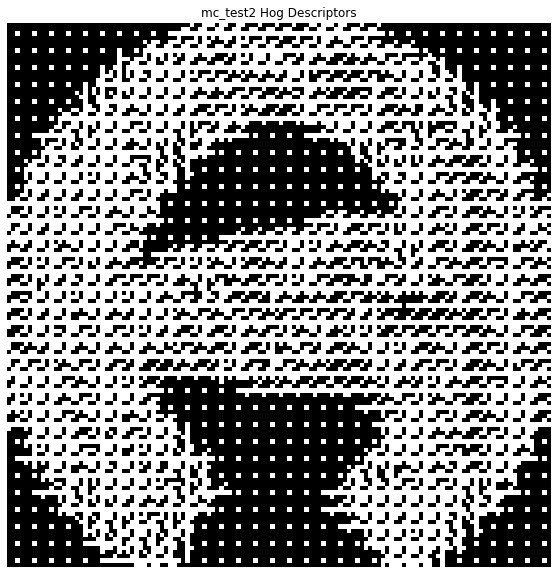

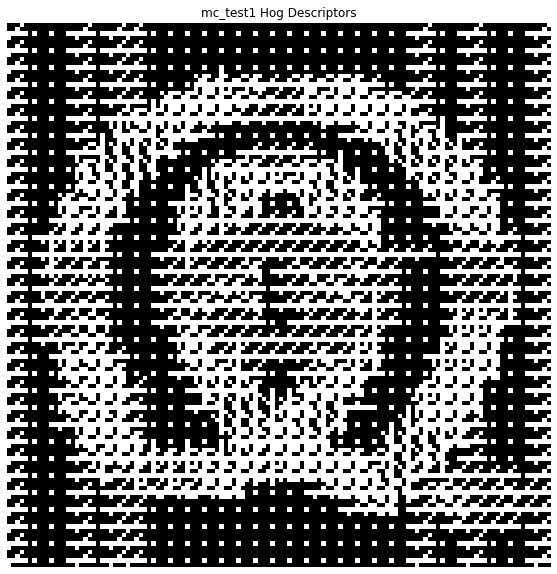

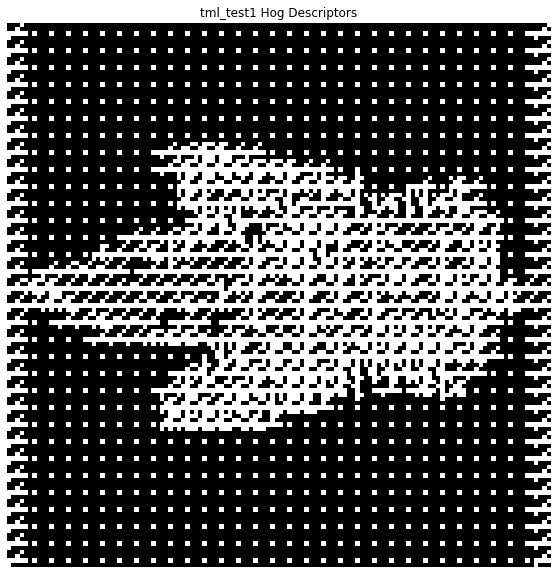

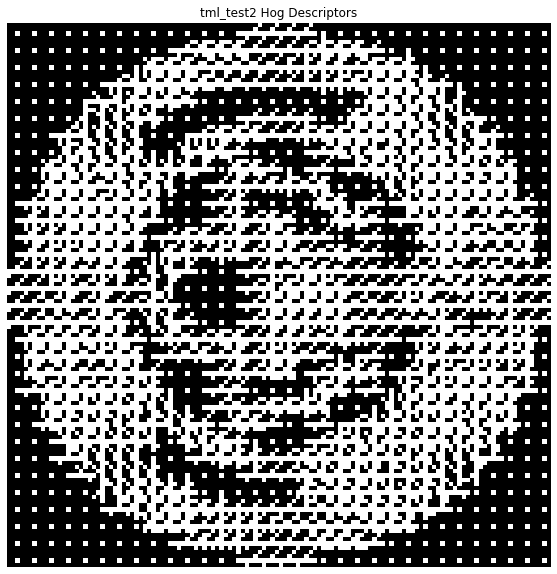

In [6]:
#Build KNN-Classifier
Classifier = KClassifier(training_path = PATH + "Data/HoG/Train",
                          testing_path = PATH + "Data/HoG/Test")
#Train Classifier with images in training_path
Classifier.train_classifier()

#Predict labels of images in testing_path
predictions = Classifier.predict()

#For all hog descriptors of testing_images, display them
for hog in Classifier.hog_descriptors_test:
    hog.display()



In [11]:
print(predictions)

right_predictions = 0
for k,v in predictions.items():
    
    if k.split('_')[0] == v:
        right_predictions +=1
        
#Print accuracy of hog predictions on test images
print('hog accuracy:' + str(right_predictions/len(predictions.items())))
        

{'mc_test2.png': 'mc', 'mc_test1.png': 'tml', 'tml_test1.png': 'tml', 'tml_test2.png': 'mc'}
hog accuracy:0.5


##### Based on the results from the HoG descriptors, the classifier achieved a 50% accuracy on the set of 4 test images, indicating that it correctly identified only 2 out of 4 images. This suggests that the classifier may not be robust to variations such as random rotations since HoG, by its inherent design, is sensitive to orientation. Specifically,the essence of HoG lies in capturing edge orientations in localized sections, which can change with rotations. Therefore, if logos undergo random rotations, the classifier's performance might be compromised. To address this, one might consider pre-processing steps like feature-based alignment or using image moments to regain a uniform orientation beforeextracting HoG features. This approach could potentially enhance the classifier's performance on rotated images.

In [14]:
#Python Class to Handle Pre-Processing of Face Images 

class FaceRecognition:
    
    def __init__(self, data_path):
        
        #Path to all face images
        self.face_path = data_path + '/GeorgiaTechDataBase'
        #List of all images in the set reshaped to 128 x 192
        self.images = [Image(path = self.face_path + '/' + filename, shape = (128,192)) for filename in os.listdir(self.face_path)]
        
        #Path to excel csv for mapping
        self.mapping_path = data_path + '/mapping.csv'
        
        #Read labels using pandas read csv
        self.mapping = pd.read_csv(self.mapping_path)
        
        # Initialize training and testing image lists
        self.train_images = []
        self.test_images = []
        
        #Set label of each images based on mapping_csv
        for img in self.images:
            #mapping uses capital S as first char while img_name uses lowercase s
            #This corrects the discrepancies
            img.img_name = img.img_name[0].upper() + img.img_name[1:]
            img.set_label(int(self.mapping[self.mapping['Image'] == img.img_name]['Label']))
            

        #Generate 80/20 train/test split for images
        self.generate_test_train_set()    
        
        
    #Generate random 80/20 split for training and testing images
    def generate_test_train_set(self):
       # Shuffle the list of images
       np.random.shuffle(self.images)
       
       # Split the images into 80% training and 20% testing
       split_index = int(0.8 * len(self.images))
       self.train_images = self.images[:split_index]
       self.test_images = self.images[split_index:]
       
       
    #Function to display 10 random images from the training image set
    #With their appropriate name and label
    def display_random_images(self, num_images=10):
     # Randomly select `num_images` from training set
     random_images = np.random.choice(self.train_images, num_images)

     # Display each image along with their respective names and labels
     for img in random_images:
         img.display(title=f"{img.img_name} - {img.label}")


    #Function to plot histograms of frequency distribution amongst the data sets
    def visualize_frequency_distribution(self):
        # For training set
        train_labels = [img.label for img in self.train_images]
        plt.figure(figsize=(12, 6))
        plt.hist(train_labels, bins=len(set(train_labels)), alpha=0.7, label='Training Set', color='blue')

        # For testing set
        test_labels = [img.label for img in self.test_images]
        plt.hist(test_labels, bins=len(set(test_labels)), alpha=0.7, label='Testing Set', color='red')

        plt.title("Frequency Distribution of Image Classes")
        plt.xlabel("Image Class/Label")
        plt.ylabel("Frequency")
        plt.legend(loc='upper right')
        plt.show()
        
        
        
        
    #Functions to do PCA using snapshot method, it takes a list of Image Objects
    
    def PCA_Analysis(self):
        #Helper function to Get list of face images flattened and gray scaled
        def flatten_images(image_list):        
            return np.array([img.img_gray.reshape(-1) for img in image_list], dtype = np.float64).T
        
        #Define D_Matrix for snapshot method
        D_Matrix = flatten_images(image_list = self.train_images)
        #Get mean of D Matrix
        mean_face = np.mean(D_Matrix, axis=0)         
        #Define centered_matrix (D matrix)
        
        #Normalize D_Matrix to its own mean
        centered_matrix = D_Matrix - mean_face
        
        # Computing covariance of the centered matrix (D.T * D)
        cov_matrix = np.dot(centered_matrix.T, centered_matrix)
        
        # Computing eigenvalues and eigenvectors of D.T * D
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix.astype(np.float64))
        
        # Sorting them by decreasing order of eigenvalues
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        # Compute the actual eigenvectors of the original data
        actual_eigenvectors = np.dot(centered_matrix, eigenvectors)    
        #Normalizing eigenvectors to unit length
        actual_eigenvectors = actual_eigenvectors / np.linalg.norm(actual_eigenvectors, axis=0)
        cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    
        #Plotting Total Variance vs Number of EigenVectors
        plt.plot(cumulative_variance)
        plt.xlabel("Number of Eigenvectors")
        plt.ylabel("Fraction of Total Variance")
        plt.show()
        
        #Plotting Normalized Variance        
        normalized_eigenvalues = eigenvalues / np.sum(eigenvalues)
        plt.plot(normalized_eigenvalues)
        plt.xlabel("Eigenvector Index")
        plt.ylabel("Normalized Variance")
        plt.show()
        
       # Create an empty list to store the eigenfaces
        eigenfaces = []
        
        # Compute and store each eigenface
        for i in range(actual_eigenvectors.shape[1]):
            eigenface = actual_eigenvectors[:, i].reshape((self.images[0].shape[1], self.images[0].shape[0]))
            eigenfaces.append(eigenface)
            
            # Optionally display the first 5 eigenfaces (or as many as you wish)
            if i < 5:
                plt.imshow(eigenface, cmap='gray')
                plt.title(f"Eigenface {i+1}")
                plt.show()
        
        # Return the list of eigenfaces
        return eigenfaces, self.train_images, self.test_images

In [15]:
#Linear Support Vector Machine Class

class SVM:

    def __init__(self, eigenfaces, train_images, test_images):
        self.eigenfaces = eigenfaces
        
        self.train_images = train_images  # List of training image objects
        self.test_images = test_images
        
        self.train_labels = [img.label for img in self.train_images]
        self.test_labels = [img.label for img in self.test_images]

        
    def train(self):
        # Project training data onto eigenface space
        flattened_train_images = [img.img_gray.ravel() for img in self.train_images]
        X_train_projected = [self.project_onto_eigenfaces(image) for image in flattened_train_images]

        # Hyperparameter tuning using GridSearchCV
        parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
        svc = SVC(kernel='linear') #Check import linear svc
        clf = GridSearchCV(svc, parameters)
        clf.fit(X_train_projected, self.train_labels)

        best_C = clf.best_params_['C']
        print(f"Best regularization parameter C: {best_C}. Chosen based on 5-fold cross-validation.")
        return clf  # Return trained SVM
    
    #Per class Accuracy helper function for Part E
    def per_class_accuracy(self, clf):
        flattened_test_images = [img.img_gray.ravel() for img in self.test_images]
        X_test_projected = [self.project_onto_eigenfaces(image) for image in flattened_test_images]
        predictions = clf.predict(X_test_projected)
        
        unique_classes = np.unique(self.test_labels)
        accuracies = {}
        for u_class in unique_classes:
            class_indices = np.where(self.test_labels == u_class)
            correct_predictions = np.sum(np.array(predictions)[class_indices] == np.array(self.test_labels)[class_indices])
            accuracy = correct_predictions / len(class_indices[0])
            accuracies[u_class] = accuracy
            
            
        # Plotting accuracies per class
        plt.bar(accuracies.keys(), accuracies.values(), color='blue')
        plt.xlabel('Class')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Class using SVM Classifier')
        plt.show()
            
        return accuracies

    def plot_histogram(self, dataset):
        if dataset == "train":
            data = self.train_labels
            title = "Training Data Class Distribution"
        else:
            data = self.test_labels
            title = "Testing Data Class Distribution"
        
        # Calculate the frequency of each label
        unique_labels, counts = np.unique(data, return_counts=True)
        frequency_dict = dict(zip(unique_labels, counts))
        
        plt.hist(data, bins=unique_labels, alpha=0.7)
        plt.title(title)
        plt.xlabel('Subject ID')
        plt.ylabel('Frequency')
        plt.show()
    
        return frequency_dict

    
    def evaluate(self, clf):
        flattened_train_images = [img.img_gray.ravel() for img in self.test_images]
        X_test_projected = [self.project_onto_eigenfaces(image) for image in flattened_train_images]
        predictions = clf.predict(X_test_projected)
        accuracy = accuracy_score(self.test_labels, predictions)
        print(f"Recognition accuracy: {accuracy * 100:.2f}%")
        return accuracy

    def project_onto_eigenfaces(self, image):
        # Project a given image onto the eigenface space
        return [np.dot(eigenface.ravel(), image) for eigenface in self.eigenfaces]
    
    
    #Helper Function to plot relationship between accuracy per class and train/test class frequency
    def scatter_plot_relationship(self,accuracy_dict, train_freq_dict, test_freq_dict):
        
        labels = list(accuracy_dict.keys())
        accuracy_vals = [accuracy_dict[key] for key in labels]
        train_freq_vals = [train_freq_dict[key] for key in labels]
        test_freq_vals = [test_freq_dict[key] for key in labels]

        plt.figure(figsize=(14, 6))

        # Scatter Plot for Training Data
        plt.subplot(1, 2, 1)
        plt.scatter(train_freq_vals, accuracy_vals, c='blue', s=50, alpha=0.6, edgecolors='w', linewidth=0.5)
        for i, label in enumerate(labels):
            plt.annotate(label, (train_freq_vals[i], accuracy_vals[i]))
        plt.title('Training Data: Accuracy vs. Frequency')
        plt.xlabel('Training Frequency')
        plt.ylabel('Accuracy')
        plt.grid(True)

        # Scatter Plot for Testing Data
        plt.subplot(1, 2, 2)
        plt.scatter(test_freq_vals, accuracy_vals, c='red', s=50, alpha=0.6, edgecolors='w', linewidth=0.5)
        for i, label in enumerate(labels):
            plt.annotate(label, (test_freq_vals[i], accuracy_vals[i]))
        plt.title('Testing Data: Accuracy vs. Frequency')
        plt.xlabel('Testing Frequency')
        plt.ylabel('Accuracy')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

In [16]:
#Random Forest Classifier Class
class RandomForestFace:

    def __init__(self, eigenfaces, train_images, test_images):
        self.eigenfaces = eigenfaces
        self.train_images = train_images
        self.test_images = test_images
        self.train_labels = [img.label for img in self.train_images]
        self.test_labels = [img.label for img in self.test_images]

    def train(self):
        # Project training data onto eigenface space
        flattened_train_images = [img.img_gray.ravel() for img in self.train_images]
        X_train_projected = [self.project_onto_eigenfaces(image) for image in flattened_train_images]

        # Hyperparameter tuning using GridSearchCV
        parameters = {'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
        rfc = RandomForestClassifier()
        clf = GridSearchCV(rfc, parameters)
        clf.fit(X_train_projected, self.train_labels)

        best_params = clf.best_params_
        print(f"Best parameters: {best_params}. Chosen based on 5-fold cross-validation.")
        return clf  # Return trained Random Forest classifier

    def evaluate(self, clf):
        flattened_test_images = [img.img_gray.ravel() for img in self.test_images]
        X_test_projected = [self.project_onto_eigenfaces(image) for image in flattened_test_images]
        predictions = clf.predict(X_test_projected)
        accuracy = accuracy_score(self.test_labels, predictions)
        print(f"Recognition accuracy: {accuracy * 100:.2f}%")
        return accuracy

    def project_onto_eigenfaces(self, image):
        # Project a given image onto the eigenface space
        return [np.dot(eigenface.ravel(), image) for eigenface in self.eigenfaces]

In [17]:
#KNN class for face evaluation
class KNNFace:
    def __init__(self, eigenfaces, train_images, test_images):
        self.eigenfaces = eigenfaces
        
        self.train_images = train_images  # List of training image objects
        self.test_images = test_images
        
        self.train_labels = [img.label for img in self.train_images]
        self.test_labels = [img.label for img in self.test_images]

    def train(self):
        # Project training data onto eigenface space
        flattened_train_images = [img.img_gray.ravel() for img in self.train_images]
        X_train_projected = [self.project_onto_eigenfaces(image) for image in flattened_train_images]

        # Hyperparameter tuning using GridSearchCV
        parameters = {'n_neighbors': list(range(1, 11))}  # Experimenting with k values from 1 to 10 for simplicity
        knn = KNeighborsClassifier(metric='euclidean')
        clf = GridSearchCV(knn, parameters)
        clf.fit(X_train_projected, self.train_labels)

        best_k = clf.best_params_['n_neighbors']
        print(f"Best value of k: {best_k}. Chosen based on 5-fold cross-validation.")
        return clf  # Return trained KNN

    def evaluate(self, clf):
        flattened_test_images = [img.img_gray.ravel() for img in self.test_images]
        X_test_projected = [self.project_onto_eigenfaces(image) for image in flattened_test_images]
        predictions = clf.predict(X_test_projected)
        accuracy = accuracy_score(self.test_labels, predictions)
        print(f"Recognition accuracy: {accuracy * 100:.2f}%")
        return accuracy

    def project_onto_eigenfaces(self, image):
        # Project a given image onto the eigenface space
        return [np.dot(eigenface.ravel(), image) for eigenface in self.eigenfaces]

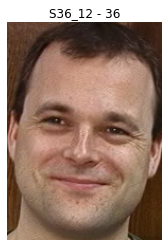

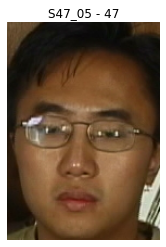

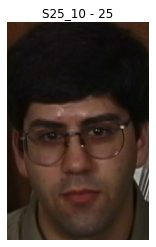

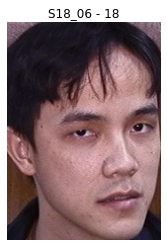

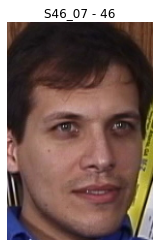

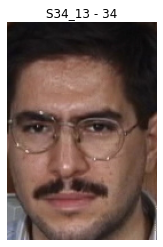

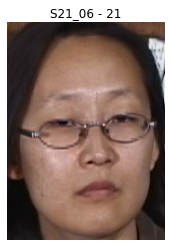

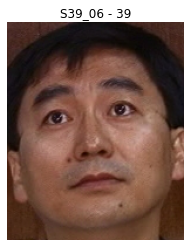

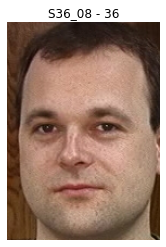

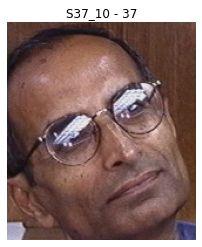

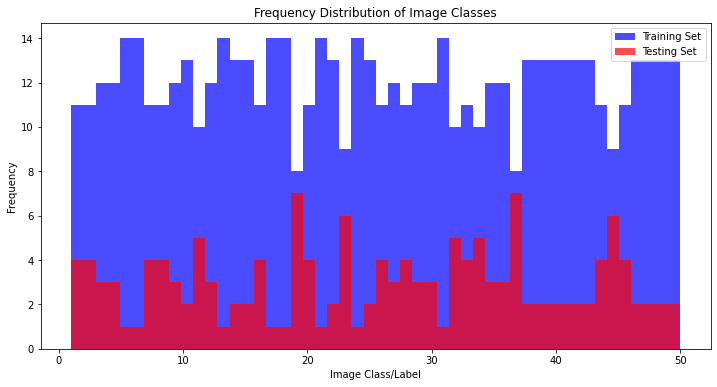

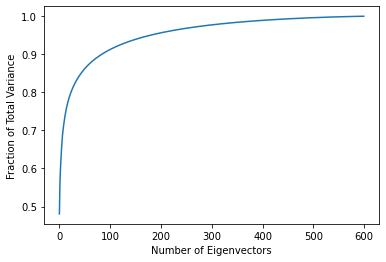

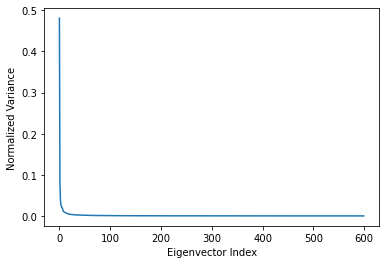

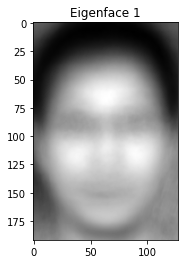

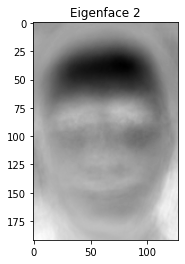

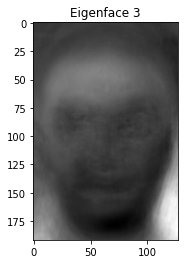

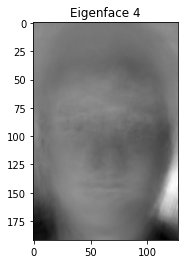

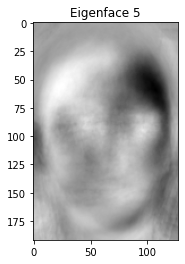

In [18]:
Recognition = FaceRecognition(data_path = PATH + "Data/FaceRecognition")
#Generate 80/20 train/test split
Recognition.generate_test_train_set()
#Display 10 random train images
Recognition.display_random_images()
#Display histograms for both data sets
Recognition.visualize_frequency_distribution()
#Snapshot method for PCA analysis. This function creates the D matrix, plots variance against the number
#of eigenvectors,normalized variance against the eigenvector indices and the 5 first eigenfaces.
#This function returns a list of all eigenfaces
eigenfaces, train_images, test_images = Recognition.PCA_Analysis()

#### Based on the plots of the normalized variance against the eigenvector index, it becomes clear that the contribution of each vector is not equally distributed. The first 10 eigenvector and eigenvalues hold the most contribution. It implies that only using these eigenvector and eigenvalues should yield a good enough representation of the data as well as reduce computations to get a good model for face recognition.


In [19]:
# Make SVM object
FaceRecognitionSVM = SVM(eigenfaces, train_images, test_images)
#Train model using SVM class
clf_SVM = FaceRecognitionSVM.train()
#Evaluate model 
FaceRecognitionSVM.evaluate(clf = clf_SVM)

Best regularization parameter C: 0.001. Chosen based on 5-fold cross-validation.
Recognition accuracy: 83.33%


0.8333333333333334

In [21]:
# Make Random Forest Classifier Object
FaceRecognitionForest = RandomForestFace(eigenfaces, train_images, test_images)
#Train Forest Recognition Object
clf_Forest = FaceRecognitionForest.train()
#Evaluate accuracy of model
FaceRecognitionForest.evaluate(clf = clf_Forest)

Best parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 500}. Chosen based on 5-fold cross-validation.
Recognition accuracy: 55.33%


0.5533333333333333

In [20]:
#Make KNN Classifier Object
FaceRecognitionKNN = KNNFace(eigenfaces, train_images, test_images)
#Train Forest Recognition Object
clf_KNN = FaceRecognitionKNN.train()
#Evaluate accuracy of model
FaceRecognitionKNN.evaluate(clf = clf_KNN)

Best value of k: 1. Chosen based on 5-fold cross-validation.
Recognition accuracy: 71.33%


0.7133333333333334

### These results are from the latest run of the classifiers. If the script is to be run another time, the results will probably differ as the test/train image sets are randomly sampled.

#### Accuracy Scores for the three classifiers, their strengths, and weaknesses:

### Linear SVM (83.33%):
#### Strengths: High accuracy suggests it effectively found the linear boundary in the eigenface feature space. Often computationally efficient and less prone to overfitting when using a good regularization parameter.

#### Weaknesses: Assumes data is linearly separable which might not always be the case for complex datasets.

### Random Forest (55.33%):
#### Strengths: Can model complex decision boundaries by leveraging multiple decision trees. It's resilient to outliers and handles non-linear data well.

#### Weaknesses: Less accurate in this context, suggesting possible overfitting or that the ensemble decision from the trees wasn't effective for the eigenface features.

### KNN (71.33%):
#### Strengths: Simple, intuitive, and doesn't assume any prior distribution on the data.

#### Weaknesses: Computationally expensive during testing as it requires comparing a test sample with all training samples. It can also be sensitive to irrelevant or redundant features.

## Analysis of Observed Differences in Performance:

#### Computational Efficiency: SVM usually requires less computational power during testing than KNN, which has to process all training data points for each test. Random Forest, while computationally intensive during training (as it builds multiple trees), can be efficient during testing.

#### Robustness to Variations: Random Forest's ensemble approach makes it quite robust to certain variations. However, its lower accuracy might suggest some sensitivity to the eigenface representation. KNN, being instance-based, might be more sensitive to variations like lighting and pose unless these variations are well-represented in the training data. SVM's performance suggests that it effectively managed these variations for the given dataset.

#### Hyperparameter Sensitivity: SVM's performance can greatly vary based on the regularization parameter. KNN is very sensitive to the choice of 'k' and the distance metric. Random Forest has multiple hyperparameters like tree depth and number of trees which can affect its performance.


### 3. Reflection on Potential Use Cases:

#### Linear SVM: Given its high accuracy and computational efficiency during testing, SVM would be ideal for real-time face recognition systems, especially when computational resources are limited.

#### Random Forest: While not the top performer in this instance, its ability to handle complex decision boundaries makes it a good choice for datasets with a lot of variations and when there's ample computational power for training.

#### KNN: Useful in scenarios where the training dataset is diverse, representing various lighting conditions, poses, and expressions. Due to its computational demands during testing, it might be more suitable for offline tasks or systems with substantial computational resources.


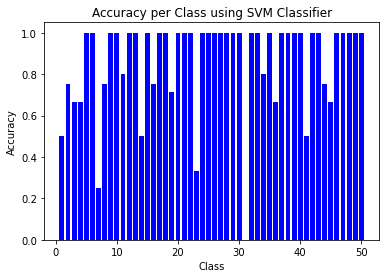

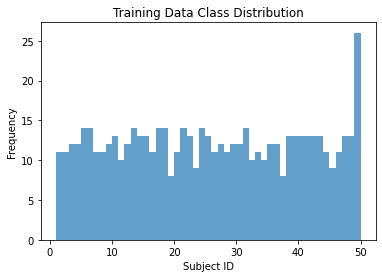

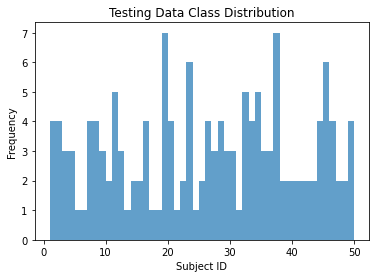

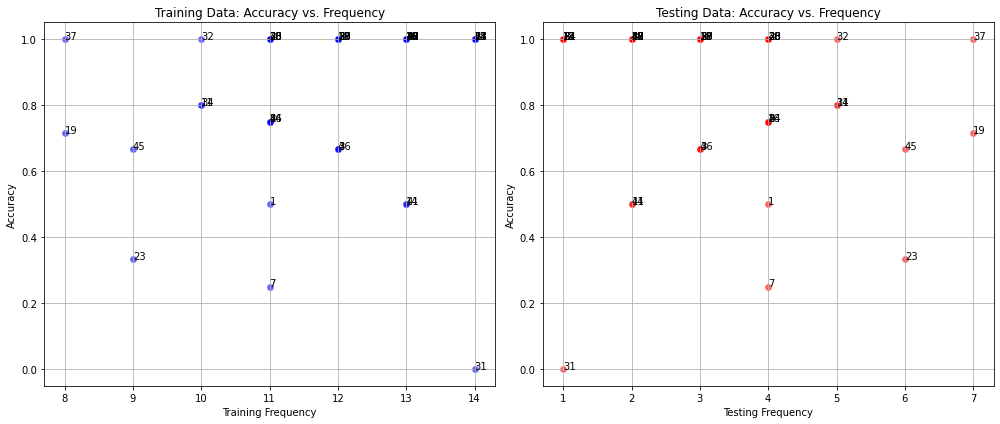

In [22]:
#Compute Accuracy per classes of SVM Model
accuracies = FaceRecognitionSVM.per_class_accuracy(clf_SVM)

# Plot histograms
train_frequency = FaceRecognitionSVM.plot_histogram("train")
test_frequency = FaceRecognitionSVM.plot_histogram("test")

#Plot scatter plot between frequency of classes in train/test set and model accuracy per class
FaceRecognitionSVM.scatter_plot_relationship(accuracies, train_frequency, test_frequency)


#### The three histograms of accuracy per class of my SVM classifier, and label frequency of my train and test samples show no particular correlation. A scatter plot can be seen that shows the relationship between these three histograms, and it is clear that there is no correlation between these values for the SVM Classifier. Based on my empirical evidence, the conclusion is that while some of the classes have equal perfect accuracies of 100% from my SVM Classifier, the frequency of these labels are completely distributed in a way to shows no correlation between these values.